In [1]:
import cv2
from google.colab import files
from matplotlib import pyplot as plt

In [3]:
# upload 'haarcascade_frontalface_default.xml' file here
uploaded_haarcascade = files.upload()

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


In [4]:
faceCascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [5]:
# upload 'faces' image here

uploaded_image = files.upload()

Saving faces.jpg to faces.jpg


## read image and convert to grayscale

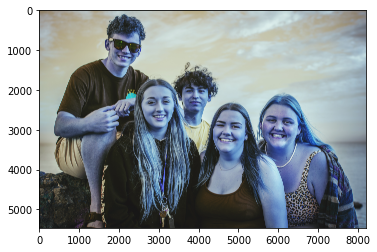

In [6]:

img = cv2.imread('faces.jpg')
plt.imshow(img)

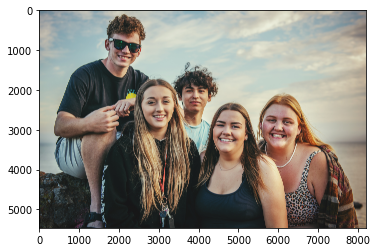

In [7]:
# convert the cv2 bgr image to rgb image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

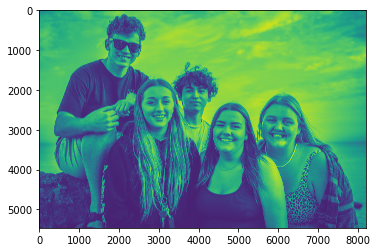

In [8]:
# convert the rgb image to greyscale
img_gr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gr)

# Detect coordinates of faces in the image

In [9]:
from matplotlib.scale import scale_factory
# create a area in the image to storing the corrdinate of faces
faces = faceCascade.detectMultiScale (
    img_gr, 
    scaleFactor=1.5,
    minNeighbors = 5,
    minSize = (30,30)
)
# show how many faces it detected (one array represent one face: x position, y position, width, and height)
print(faces)
print('Faces found: ', len(faces))

[[3440 1653  923  923]
 [2533 1945  923  923]
 [5562 2435  923  923]
 [4252 2545  923  923]
 [7645 4348   81   81]
 [ 376 4578   54   54]]
Faces found:  6


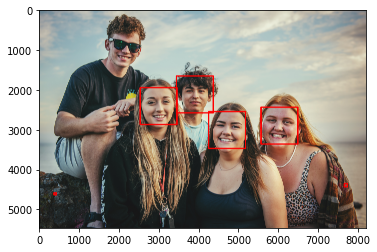

In [10]:
# draw rectangle on the face
image = cv2.imread('faces.jpg')
for (x,y,w,h) in faces:
  cv2.rectangle(image, (x,y), (x+w, y+h), (0,0,255), 32)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2022-08-19 15:41:39--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2022-08-19 15:41:40 (14.1 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2022-08-19 15:41:40--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [ ]:
from imutils.video import VideoStream
import numpy as np
import imutils
import time
from google.colab.patches import cv2_imshow

# Loading prototxt and cafe model. And start VideoStream to switch on or startup the video source
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [ ]:
#procesess the import image with opencv
image = cv2.imread('faces.jpg')
image = imutils.resize(image, width=600)

# extract the dimensions and converting image into blobFromImage
(h,w) = image.shape[:2]
# blobImage convert RGB (104, 177, 123)
blob = cv2.dnn.blobFromImage(image,1.0,(300,300),(104, 177, 123))

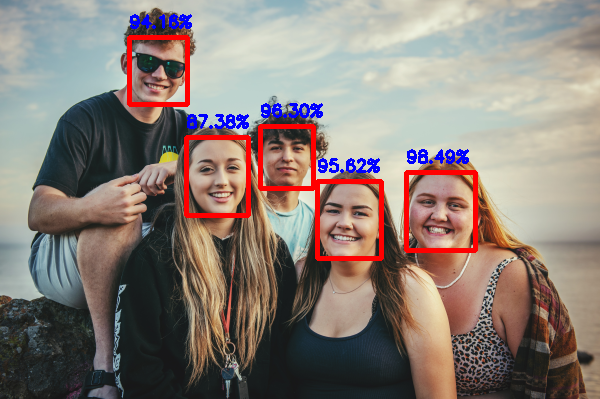

In [ ]:

#passing blob through the network to detect and prediction
net.setInput(blob)
detections = net.forward()
# loop over the detections
for i in range(0, detections.shape[2]):

  # extract the confidence and prediction
  confidence = detections[0, 0, i, 2]

  # filter detections by confidence greater than the minimum confidence
  if confidence > 0.5:
    # compute the (x, y)-coordinates of the bounding box for the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # draw the bounding box of the face along Confidance probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 4)
    cv2.putText(image, text, (startX, y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 2)


cv2_imshow(image)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    video = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # extract the dimensions and converting image into blobFromImage
    (h,w) = video.shape[:2]
    # blobImage convert RGB
    blob = cv2.dnn.blobFromImage(cv2.resize(video,(300,300)),1.0,(300,300),(104, 177, 123))
    net.setInput(blob)
    detections = net.forward()
    # loop over the detections
    for i in range(0, detections.shape[2]):

      # extract the confidence and prediction
      confidence = detections[0, 0, i, 2]

      # filter detections by confidence greater than the minimum     #confidence
      if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for the
        # object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # draw the bounding box of the face along Confidance
        # probability
        text = "{:.2f}%".format(confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        bbox_array = cv2.rectangle(bbox_array, (startX, startY), (endX, endY), (255, 0, 0), 4)
        bbox_array = cv2.putText(bbox_array, text, (startX, y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
    
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
      
   

  

<IPython.core.display.Javascript object>